In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf


from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
data_path = '/content/drive/My Drive/Colab Notebooks/AutoEncoders/Advanced_ML_HSE/Face_Keypoint_Kaggle'

In [ ]:
# check the training file: 
train_read = pd.read_csv(data_path + '/training.csv', sep=',')
print ('training data shape; ', train_read.shape)

training data shape;  (7049, 31)


### Data Description from Kaggle; 

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip. 

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

Data files:

    * training.csv: 7049 images. Each row contains the (x,y) for 15 keypoints, and image as row-ordered list of pixels.
    * test.csv: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels

_So 31 cols represent 15 keypoints (x2) and corresponding image_     

In [ ]:
train_read.head(3).T

,0,1,2
left_eye_center_x,66.0336,64.3329,65.0571
left_eye_center_y,39.0023,34.9701,34.9096
right_eye_center_x,30.227,29.9493,30.9038
right_eye_center_y,36.4217,33.4487,34.9096
left_eye_inner_corner_x,59.5821,58.8562,59.412
left_eye_inner_corner_y,39.6474,35.2743,36.321
left_eye_outer_corner_x,73.1303,70.7227,70.9844
left_eye_outer_corner_y,39.97,36.1872,36.321
right_eye_inner_corner_x,36.3566,36.0347,37.6781
right_eye_inner_corner_y,37.3894,34.3615,36.321


In [ ]:
# check for null values in the training data: 

print ('nan in every cols: ', train_read.isna().sum())

nan in every cols:  left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x   

In [ ]:
# for i in range(30):
#   print (type(train_read.columns[i]))
# plt.hist(train_read[train_read.columns[0]], bins=50)

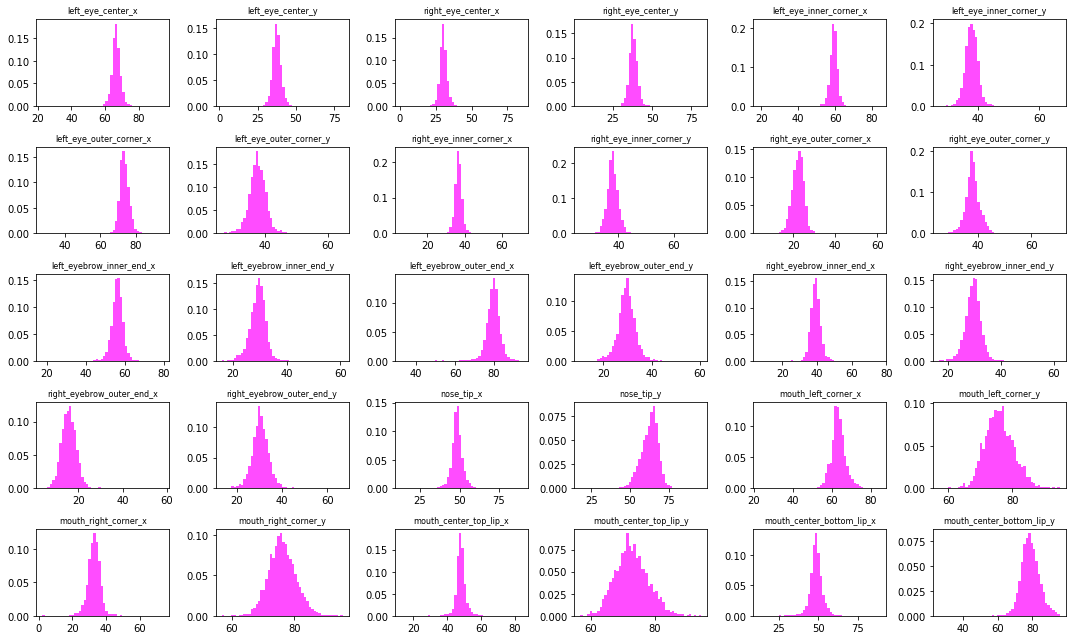

In [ ]:
fig, axes = plt.subplots(5, 6, figsize=(15, 9))
ax = axes.ravel() 
for i in range(30):
  ax[i].hist(train_read[train_read.columns[i]], bins=50, density=True, alpha=0.7, color='magenta')
  ax[i].set_title(train_read.columns[i],fontsize=8)
  # ax[i].axes.get_xaxis().set_visible(False)
plt.tight_layout()  
plt.savefig(data_path + 'points_dist.png', dpi=200)

* As expected the keypoints do follow a normal distribution. 
* So we can actually fill the NaN entries with the distribution mean as one of the simplest strategies.   

Here we can test two different workflows. First one is we only use the clean data i.e. drop all the rows with NaN and train a model. 

Second workflow will use data imputation.  For data imputation, from ML perspective it is necessary to first split the data into train-test and then apply the transformation otherwise we are prone to induce data-leakage.   

Finally, decided to work with only the clean data.  

In [ ]:
train_clean = train_read.dropna(axis=0, how='any', inplace=False)
train_clean = train_clean.reset_index(drop=True)

In [ ]:
# Most of the columns have null values
# we will impute them by 'pad/ffill' method 
# as we expect the missing value of facial kaypoints to be somewhere close to the others 

# train_read.fillna(method='pad', inplace=True)
# print ('nan in every cols after imputing: ', train_read.isna().sum())

In [ ]:
print ('data-frame shape with no null values: ', train_clean.shape)
print ('data-frame colummn names; ', train_clean.columns)

data-frame shape with no null values:  (2140, 31)
data-frame colummn names;  Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')


In [ ]:
# train_read[['Image']].head(2)
all_imgs = []
print (train_read[['Image']].shape)
for i in range(0, 7049):
  x = train_read['Image'][i].split(' ') # split the pixel values based on the space 
  x = [y for y in x] # create the listed pixels
  all_imgs.append(x)
all_imgs_arr = np.array(all_imgs, dtype='float') # arrays are always better than lists :)

(7049, 1)


In [ ]:
# train_clean[['Image']].tail(8)
# print (len(train_clean))

In [ ]:
# train_clean[['Image']].head(2)
clean_imgs = []
# print (train_clean[['Image']].shape)
for i in range(0, len(train_clean)):
  x_c = train_clean['Image'][i].split(' ') # split the pixel values based on the space 
  x_c = [y for y in x_c] # create the listed pixels
  clean_imgs.append(x_c)
clean_imgs_arr = np.array(clean_imgs, dtype='float') # arrays are always better than lists

In [ ]:
# print (all_imgs_arr.shape)
# all_imgs_arr = np.reshape(all_imgs_arr, (7049, 96, 96, 1))
# train_ims = all_imgs_arr/255.

In [ ]:
clean_imgs_arr = np.reshape(clean_imgs_arr, (train_clean.shape[0], 96, 96, 1))
train_ims_clean = clean_imgs_arr/255.

# plt.imshow(all_imgs_arr[10].reshape(96, 96), cmap='gray')

In [ ]:
# keypoints_df = train_read.drop('Image', axis=1)
# # print ('check shape after dropping Image col: ', keypoints_df.shape)

# keypoints_arr = keypoints_df.to_numpy()
# print ('check shape: ', keypoints_arr.shape)

# # # train_points_arr = keypoints_arr  

check shape:  (7049, 30)


In [ ]:
clean_keypoints_df = train_clean.drop('Image', axis=1)
print ('check shape after dropping Image col in clean df: ', clean_keypoints_df.shape)

clean_keypoints_arr = clean_keypoints_df.to_numpy()
print ('check shape of clean keypoints arr: ', clean_keypoints_arr.shape)

check shape after dropping Image col in clean df:  (2140, 30)
check shape of clean keypoints arr:  (2140, 30)


In [ ]:
# normalize the points so that training is easier
# we didn't use it later
# print ('check few values: ', keypoints_arr[0], keypoints_arr[1]) 

def standardize_keypoint(keypoints):
  y_points = (keypoints - 48.)/48. 
  print ('check keypoints max and min: ', np.max(y_points), np.min(y_points))
  return y_points


# train_points_arr = standardize_keypoint(keypoints_arr)
# train_points_arr = standardize_keypoint(clean_keypoints_arr)
# print ('\n')
# print ('check few vals after standardize: ', train_points_arr[0], train_points_arr[1])

In [ ]:
# fig, ax = plt.subplots(figsize=(5, 4))
def vis_im_keypoint(img, points, axs):
  # fig = plt.figure(figsize=(6, 4))
  axs.imshow(img.reshape(96, 96))
  # points should be in the standardized 
  xcoords = 48* (points[0::2] + 1.)
  ycoords = 48* (points[1::2] + 1.) 
  axs.scatter(xcoords, ycoords, color='red', marker='o')

# vis_im_keypoint(train_ims[5], train_points_arr[5], ax)  

def vis_im_keypoint_notstandard(img, points, axs): # same function as before but deals with keypoints when they are not standardized
  # fig = plt.figure(figsize=(6, 4))
  axs.imshow(img.reshape(96, 96))
  xcoords = (points[0::2] + 0.)
  ycoords = (points[1::2] + 0.) 
  axs.scatter(xcoords, ycoords, color='red', marker='o')


### Try Training Without Augmentation Using a VGG Like Network  

We later found the submssion score in Kaggle was poor using this simplest approach.   

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, \
     Flatten, BatchNormalization, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import elu, relu
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [ ]:
# input_im = Input(shape=(96, 96, 1))
# def model():
#   #layer 1: 
#   conv1 = Conv2D(32, (3, 3), activation='relu', )(input_im) #96 x 96 x 32
#   conv2 = Conv2D(32, (3, 3), activation='relu', )(conv1) #96 x 96 x 32
#   pool1 = MaxPooling2D((2, 2))(conv2) 
#   conv3 = Conv2D(64, (3, 3), activation='relu', )(pool1) #48 x 16 x 64
#   conv4 = Conv2D(64, (3, 3), activation='relu', )(conv3)
#   pool2 = MaxPooling2D(pool_size=(2, 2))(conv4)
#   conv5 = Conv2D(128, (3, 3), padding='same', activation='relu',)(pool2)
#   conv6 = Conv2D(128, (3, 3), padding='same', activation='relu',)(conv5)
#   conv7 = Conv2D(128, (3, 3), padding='same', activation='relu',)(conv6)
#   pool3 = MaxPooling2D(pool_size=(2, 2))(conv7)
#   conv8 = Conv2D(256, (3, 3), padding='same', activation='relu',)(pool3)
#   conv9 = Conv2D(256, (3, 3), padding='same', activation='relu',)(conv8)
#   conv10 = Conv2D(256, (3, 3), padding='same', activation='relu',)(conv9)
#   pool4 = MaxPooling2D(pool_size=(2, 2))(conv10)
#   flat = Flatten()(pool4)
#   den1 = Dense(128, activation='relu')(flat)
#   den1 = Dropout(0.20)(den1)
#   den2 = Dense(64, activation='relu')(den1)
#   den2 = Dropout(0.20)(den2)
#   pred = Dense(clean_keypoints_arr.shape[1])(den2)
#   model = Model(inputs=input_im, outputs=pred, name='VGG_Like')
#   return model 

In [ ]:
# face_key_model = model()
# face_key_model.summary()

In [ ]:
class customCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.epoch = epoch + 1
    if self.epoch % 50 == 0:
      print ('epoch num {}, train acc: {}, validation acc: {}'.format(epoch, logs['mae'], logs['val_mae']))


learning_rate = 1e-3

def lrdecay(epoch):
  lr = learning_rate
  if epoch > 1600:
    lr *= 1e-1
  elif epoch > 800:
    lr *= 3e-1
  elif epoch > 400:
    lr *= 5e-1
  elif epoch > 200:
    lr *= 7e-1
  elif epoch > 100:
    lr *= 9e-1
  if epoch % 50 == 0:    
    print('Learning rate: ', lr)    
  return lr


def lrexpdecay(epoch):
  decay = 0.1
  lr = learning_rate*(np.exp(-decay*epoch))
  return lr


def earlystop(mode):
  if mode=='acc':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=20, mode='max')
  elif mode=='loss':
    estop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min')
  return estop



reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.8,
                              patience=25, min_lr=1e-5, verbose=1)



  # if epoch < 40:
  #   return 0.01
  # else:
  #   return 0.01 * np.math.exp(0.03 * (40 - epoch))

lrdecay = tf.keras.callbacks.LearningRateScheduler(lrdecay) # learning rate decay

sgd = SGD(lr=learning_rate, momentum = 0.9,nesterov=True)
adam = Adam(learning_rate=learning_rate)

In [ ]:

# face_key_model.compile(loss='mse', 
#                        optimizer=sgd, 
#                        metrics=['acc'])

In [ ]:
# predict_points = face_key_model.predict(test_ims)

# print ('check shape of predicted points: ', predict_points.shape)

In [ ]:
# print (predict_points[0][0::2]*96)

## Include Augmentation 

1. Horizontal Flip. 
2. Linear Contrast.  
3. Gaussian Blur. 
4. Rotation. 
5. Scaling. 

In [ ]:
def flip_im_points1(img, points):
  flip_im = np.fliplr(img)
  xcoords = points[0::2]
  ycoords = points[1::2]
  new_points = []
  for i in range(len(xcoords)):
    xp = xcoords[i]
    yp = ycoords[i]
    new_points.append(xp*(-1))
    new_points.append(yp)
  return flip_im, np.asarray(new_points)  

def flip_im_points0(img, points): # flip keypoints when they are not standardized 
  flip_im = np.fliplr(img)
  xcoords = points[0::2]
  ycoords = points[1::2]
  new_points = []
  for i in range(len(xcoords)):
    xp = xcoords[i]
    yp = ycoords[i]
    new_points.append(96-xp)
    new_points.append(yp)
  return flip_im, np.asarray(new_points)    

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa

def gnoise_lincontrast(im_tr, pt_tr):
  seq = iaa.Sequential([iaa.LinearContrast((0.6, 1.5)), 
                        iaa.Sometimes(
        0.80, iaa.GaussianBlur(sigma=(0., 2.0)))])
  aug_ims = []
  aug_pts = []
  for im, pt in zip(im_tr, pt_tr):
    #f_im, f_pts = flip_im_points1(im, pt)
    f_im = seq(image=im)
    aug_ims.append(im)
    aug_ims.append(f_im)
    aug_pts.append(pt)
    aug_pts.append(pt)
  return np.asarray(aug_ims), np.asarray(aug_pts)

In [ ]:
aug_ims_train_clean_g, aug_points_train_clean_g = gnoise_lincontrast(train_ims_clean, clean_keypoints_arr)
print (type(aug_ims_train_clean_g), aug_ims_train_clean_g.shape, aug_points_train_clean_g.shape)

<class 'numpy.ndarray'> (4280, 96, 96, 1) (4280, 30)


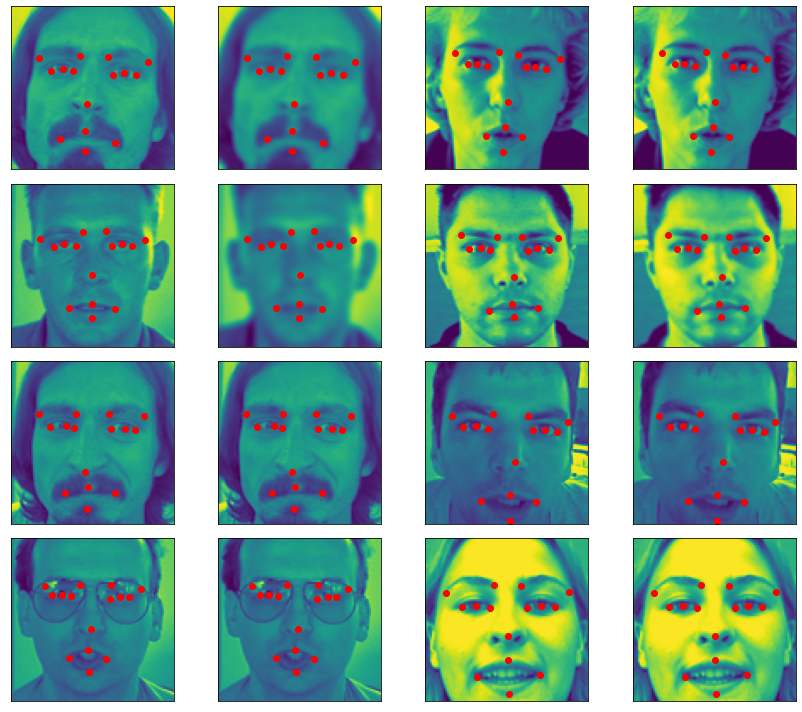

In [ ]:
fig = plt.figure(figsize=(12, 10))
npics= 16
count = 1
for i in range(npics):
  ipic = i # use this to see original and augmented image side by side
#   ipic = np.random.choice(aug_ims_train_clean.shape[0])
  ax = fig.add_subplot(npics/4 , 4, count, xticks=[],yticks=[])
  vis_im_keypoint_notstandard(aug_ims_train_clean_g[ipic], aug_points_train_clean_g[ipic], ax)
  count = count + 1

# plt.title('Gaussian Blur and Linear Contrast')
plt.tight_layout()
plt.savefig(data_path+'/aug_ims_kps_gauss_cont.png', dpi=200)

plt.show()    

In [ ]:
# include rotation augmentation 

from imgaug.augmentables import Keypoint, KeypointsOnImage

def rotate_aug(im_tr, pt_tr):
  seq = iaa.Sequential([iaa.Affine(rotate=15, scale=(0.8, 1.2))])
  #image_aug, kps_aug = seq(image=image, keypoints=kps)
  aug_ims = []
  aug_pts = []
  coordlist = []
  for im, pt in zip(im_tr, pt_tr):
    #f_im, f_pts = flip_im_points1(im, pt)
    xcoord = pt[0::2]
    ycoord = pt[1::2]
    for i in range(len(xcoord)): 
      coordlist.append(Keypoint(xcoord[i], ycoord[i]))
    kps = KeypointsOnImage(coordlist, shape=im.shape)  
    f_im, f_kp = seq(image=im, keypoints=kps)
    #new_xcoords = []
    #new_ycoords = []
    all_coords = []
    for k in range(len(kps.keypoints)):
      before = kps.keypoints[k]
      after = f_kp.keypoints[k]
      # print("Keypoint %d: (%.8f, %.8f) -> (%.8f, %.8f)" % (
      #     i, before.x, before.y, after.x, after.y)
      # )
      all_coords.append(after.x)
      all_coords.append(after.y)
      all_coords_arr = np.asarray(all_coords)
    aug_ims.append(im)
    aug_ims.append(f_im)
    aug_pts.append(pt)
    aug_pts.append(all_coords)
    coordlist.clear()
  return np.asarray(aug_ims), np.asarray(aug_pts)

In [ ]:
aug_ims_train_clean_g2, aug_points_train_clean_g2 = rotate_aug(aug_ims_train_clean_g, aug_points_train_clean_g)

print (type(aug_ims_train_clean_g2), aug_ims_train_clean_g2.shape, aug_points_train_clean_g2.shape)

<class 'numpy.ndarray'> (8560, 96, 96, 1) (8560, 30)


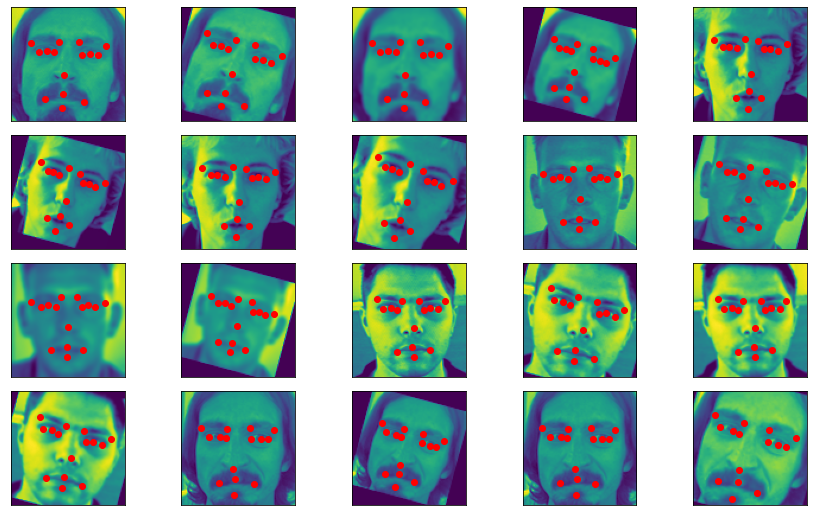

In [ ]:
fig = plt.figure(figsize=(12, 9))
npics= 20
count = 1
for i in range(npics):
  ipic = i # use this to see original and augmented image side by side
#   ipic = np.random.choice(aug_ims_train_clean.shape[0])
  ax = fig.add_subplot(npics/4 , 5, count, xticks=[],yticks=[])
  vis_im_keypoint_notstandard(aug_ims_train_clean_g2[ipic], aug_points_train_clean_g2[ipic], ax)
  count = count + 1


plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.tight_layout()

plt.tight_layout()
plt.savefig(data_path+'/aug_ims_kps_rot_scale.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [ ]:
### add the flipped images in the training data-set
def aug_flip(im_tr, pt_tr):
  aug_ims = []
  aug_pts = []
  for im, pt in zip(im_tr, pt_tr):
    f_im, f_pts = flip_im_points1(im, pt)
    aug_ims.append(im)
    aug_ims.append(f_im)
    aug_pts.append(pt)
    aug_pts.append(f_pts)
  return np.asarray(aug_ims), np.asarray(aug_pts)

def aug_flip0(im_tr, pt_tr):
  aug_ims = []
  aug_pts = []
  for im, pt in zip(im_tr, pt_tr):
    f_im, f_pts = flip_im_points0(im, pt)
    aug_ims.append(im)
    aug_ims.append(f_im)
    aug_pts.append(pt)
    aug_pts.append(f_pts)
  return np.asarray(aug_ims), np.asarray(aug_pts)

In [ ]:
aug_ims_train_clean_g3, aug_points_train_clean_g3 = aug_flip0(aug_ims_train_clean_g2, 
                                                         aug_points_train_clean_g2)

print ('size of training data now: ', aug_ims_train_clean_g3.shape, aug_points_train_clean_g3.shape)


size of training data now:  (17120, 96, 96, 1) (17120, 30)


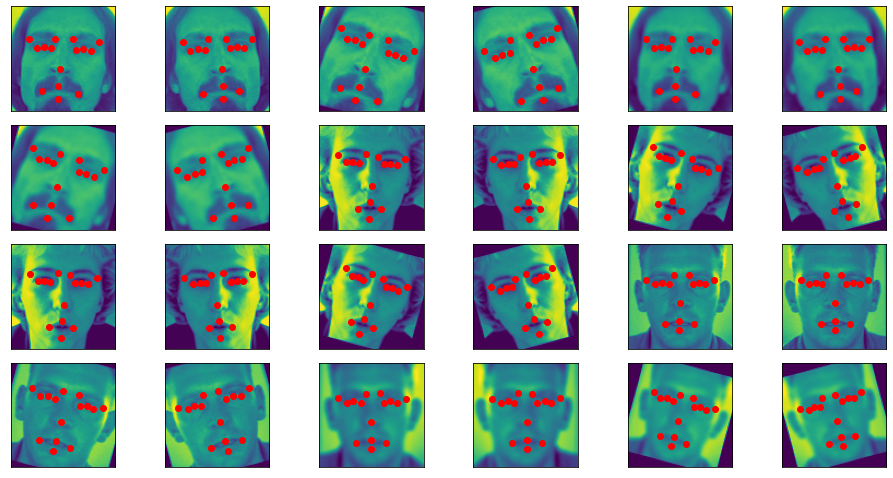

In [ ]:
fig = plt.figure(figsize=(13, 10))
npics= 24
count = 1
for i in range(npics):
  ipic = i # use this to see original and augmented image side by side
#   ipic = np.random.choice(aug_ims_train_clean.shape[0])
  ax = fig.add_subplot(npics/4 , 6, count, xticks=[],yticks=[])
  vis_im_keypoint_notstandard(aug_ims_train_clean_g3[ipic], aug_points_train_clean_g3[ipic], ax)
  count = count + 1




plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.tight_layout()

plt.savefig(data_path+'/aug_ims_kps_flip_h.png', bbox_inches = 'tight', pad_inches = 0, dpi=200)
plt.show()

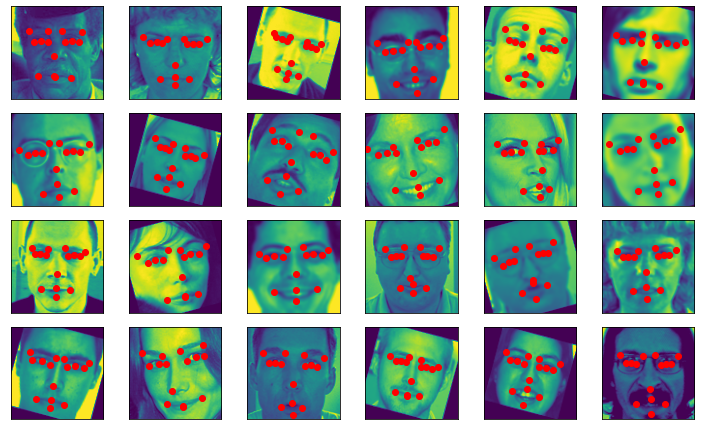

In [ ]:
fig = plt.figure(figsize=(10, 9))
npics= 24
count = 1
for i in range(npics):
  #ipic = i # use this to see original and augmented image side by side
  ipic = np.random.choice(aug_ims_train_clean_g3.shape[0])
  ax = fig.add_subplot(npics/4 , 6, count, xticks=[],yticks=[])
  vis_im_keypoint_notstandard(aug_ims_train_clean_g3[ipic], aug_points_train_clean_g3[ipic], ax)
  count = count + 1


plt.tight_layout()
plt.show()

In [ ]:
# ipic = np.random.choice(train_ims.shape[0])
# check_flip_im1, check_flip_points1 = flip_im_points1(train_ims[ipic], train_points_arr[ipic])

# fig, ax = plt.subplots(figsize=(4, 4))

# vis_im_keypoint(train_ims[ipic], train_points_arr[ipic], ax)
# plt.title('Before Horizontal Flip')
# fig, ax1 = plt.subplots(figsize=(4, 4))
# vis_im_keypoint(check_flip_im1, check_flip_points1, ax1)
# plt.title('After Horizontal Flip')
# plt.show()

In [ ]:
# from sklearn.model_selection import train_test_split
# imgs_train, imgs_val, points_train, points_val = train_test_split(train_ims, train_points_arr, 
#                                                                   test_size=0.15, random_state=21)

In [ ]:

# imgs_train, imgs_val, points_train, points_val = train_test_split(train_ims, keypoints_arr, 
#                                                                   test_size=0.15, random_state=21)
# print ('train image data size: ', imgs_train.shape)
# print ('train keypoints data size: ', points_train.shape)
# print ('validation image data size: ', imgs_val.shape)

# imgs_train_clean, imgs_val_clean, points_train_clean, points_val_clean = train_test_split(train_ims_clean, clean_keypoints_arr, 
#                                                                   test_size=0.15, random_state=21)

# print ('train clean image data size: ', imgs_train_clean.shape)
# print ('train clean keypoints data size: ', points_train_clean.shape)
# print ('validation clean image data size: ', imgs_val_clean.shape)

In [ ]:
# # now we perform the imputation separately on the train and validation keypoints separately 
# print ('check if nan exixts in the train and valid set; ', np.isnan(np.min(points_train)), np.isnan(np.min(points_val))) 

# import numpy.ma as ma # masked array
# points_train_imputed = np.where(np.isnan(points_train), ma.array(points_train, mask=np.isnan(points_train)).mean(axis=0), 
#                                 points_train)
# points_val_imputed = np.where(np.isnan(points_val), ma.array(points_val, mask=np.isnan(points_val)).mean(axis=0), 
#                                 points_val)
# print ('check if nan exixts in the train and valid set after imputation; ', 
#        np.isnan(np.min(points_train_imputed)), np.isnan(np.min(points_val_imputed)))

check if nan exixts in the train and valid set;  True True
check if nan exixts in the train and valid set after imputation;  False False


In [ ]:
# points_train_standardize = standardize_keypoint(points_train_imputed)
# points_val_standardize = standardize_keypoint(points_val_imputed)

# print ('check example standardize keypoint: ', points_train_standardize[10])

In [ ]:
# points_train_standardize_clean = standardize_keypoint(points_train_clean)
# points_val_standardize_clean = standardize_keypoint(points_val_clean)

# print ('check example standardize keypoint: ', points_train_standardize_clean[10])

In [ ]:
# aug_ims_train, aug_points_train = aug_sample(imgs_train, points_train_standardize)
# aug_ims_train_clean, aug_points_train_clean = aug_sample(imgs_train_clean, points_train_standardize_clean)
# aug_ims_train_clean0, aug_points_train_clean0 = aug_flip0(imgs_train_clean, points_train_clean)

In [ ]:
from sklearn.utils import shuffle
aug_ims_train_final, aug_points_train_final = shuffle(aug_ims_train_clean_g3, aug_points_train_clean_g3)
print ('check number of training files: ', len(aug_points_train_final))


check number of training files:  17120


In [ ]:
### let's try to predict some keypoints on the test data-set
test_read = pd.read_csv(data_path + '/test.csv', sep=',')
print ('test dataframe shape; ', test_read.shape)
test_read.head(3)

test dataframe shape;  (1783, 2)


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...


In [ ]:
test_ims = []

for i in range(0, 1783):
  x_t = test_read['Image'][i].split(' ') # split the pixel values based on the space 
  x_t = [y for y in x_t] # create the listed pixels
  test_ims.append(x_t)
test_imgs_arr = np.array(test_ims, dtype='float') # arrays are always better than lists

test_imgs_arr = np.reshape(test_imgs_arr, (1783, 96, 96, 1))
test_ims = test_imgs_arr/255.

In [ ]:
# lookup_table = pd.read_csv('../input/facial-keypoints-detection/IdLookupTable.csv')
# print ('lookup table shape: ', lookup_table.shape)
# lookup_table.head()

In [ ]:
# the required format of output
# sub_form_table = pd.read_csv('../input/facial-keypoints-detection/SampleSubmission.csv')
# sub_form_table.head()


In [ ]:
def inception_like(input_layer, filter1, filter2, filter3):
  # 1x1 conv
  conv1 = Conv2D(filter1, (1,1), padding='same', activation='relu')(input_layer)
  bn1 = BatchNormalization()(conv1)
  # 3x3 conv
  conv3 = Conv2D(filter2, (3,3), padding='same', activation='relu')(input_layer)
  bn3 = BatchNormalization()(conv3)
  # 5x5 conv
  conv5 = Conv2D(filter3, (5,5), padding='same', activation='relu')(input_layer)
  bn5 = BatchNormalization()(conv5)
  # 3x3 max pooling
#   pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
  pool = MaxPooling2D((2,2), strides=(1,1), padding='same')(input_layer)
  # concatenate filters, assumes filters/channels last
  layer_out = Concatenate(axis=-1)([bn3, bn5, pool])
  return layer_out


In [ ]:
input_im = Input(shape=(96, 96, 1))
def model2():
#   x = Conv2D(64, (3, 3), padding='same', strides=(2, 2), activation='relu', )(input_im)
#   x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), )(x)
#   x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', )(x)
# #   x =  Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', )(x) 
#   x = Conv2D(96, (3, 3), padding='same', strides=(1, 1), activation='relu', )(x)
#   x = MaxPooling2D((3, 3), padding='same', strides=(2, 2) )(x)
#   x = Conv2D(16, (3, 3), padding='same', activation='relu', )(input_im)
#   x = Conv2D(32, (3, 3), padding='same', activation='relu', )(input_im)  
#   x = Conv2D(64, (3, 3), padding='same', activation='relu', )(x)  
  x1 = inception_like(input_im, 64, 64, 32)
  x1 = MaxPooling2D((3, 3), padding='same', strides=(2, 2) )(x1)

  x2 = inception_like(x1, 64, 64, 32)
  x2 = MaxPooling2D((3, 3), padding='same', strides=(2, 2) )(x2)
  
  x2_1 = inception_like(x2, 96, 96, 64)
  x2_1 = MaxPooling2D((3, 3), padding='same', strides=(2, 2) )(x2_1)  

  x3 = inception_like(x2_1, 96, 128, 64)
  #x3 = MaxPooling2D((3, 3), padding='same', strides=(2, 2) )(x3)
  x3 = MaxPooling2D()(x3)

  x3_1 = inception_like(x3, 128, 256, 128)
  #x3_1 = MaxPooling2D((3, 3), padding='same', strides=(2, 2) )(x3_1) 
  x3_1 = GlobalAveragePooling2D()(x3_1)

  x4 = Flatten()(x3_1)
  x4 = Dense(1024, kernel_regularizer=l2(l2=0.03))(x4)
  x4 = Dropout(0.2)(x4)

  #x5 = Dense(128, kernel_regularizer=l2(l2=0.02))(x4)
  #x5 = Dropout(0.1)(x5)

  pred = Dense(30)(x4)
  model = Model(inputs=input_im, outputs=pred, name='Inception_Like')

  return model

In [ ]:
face_key_model2_aug = model2()
face_key_model2_aug.summary()

Model: "Inception_Like"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 64)   256         conv2d_1[0][0]                   
_____________________________________________________________________________________

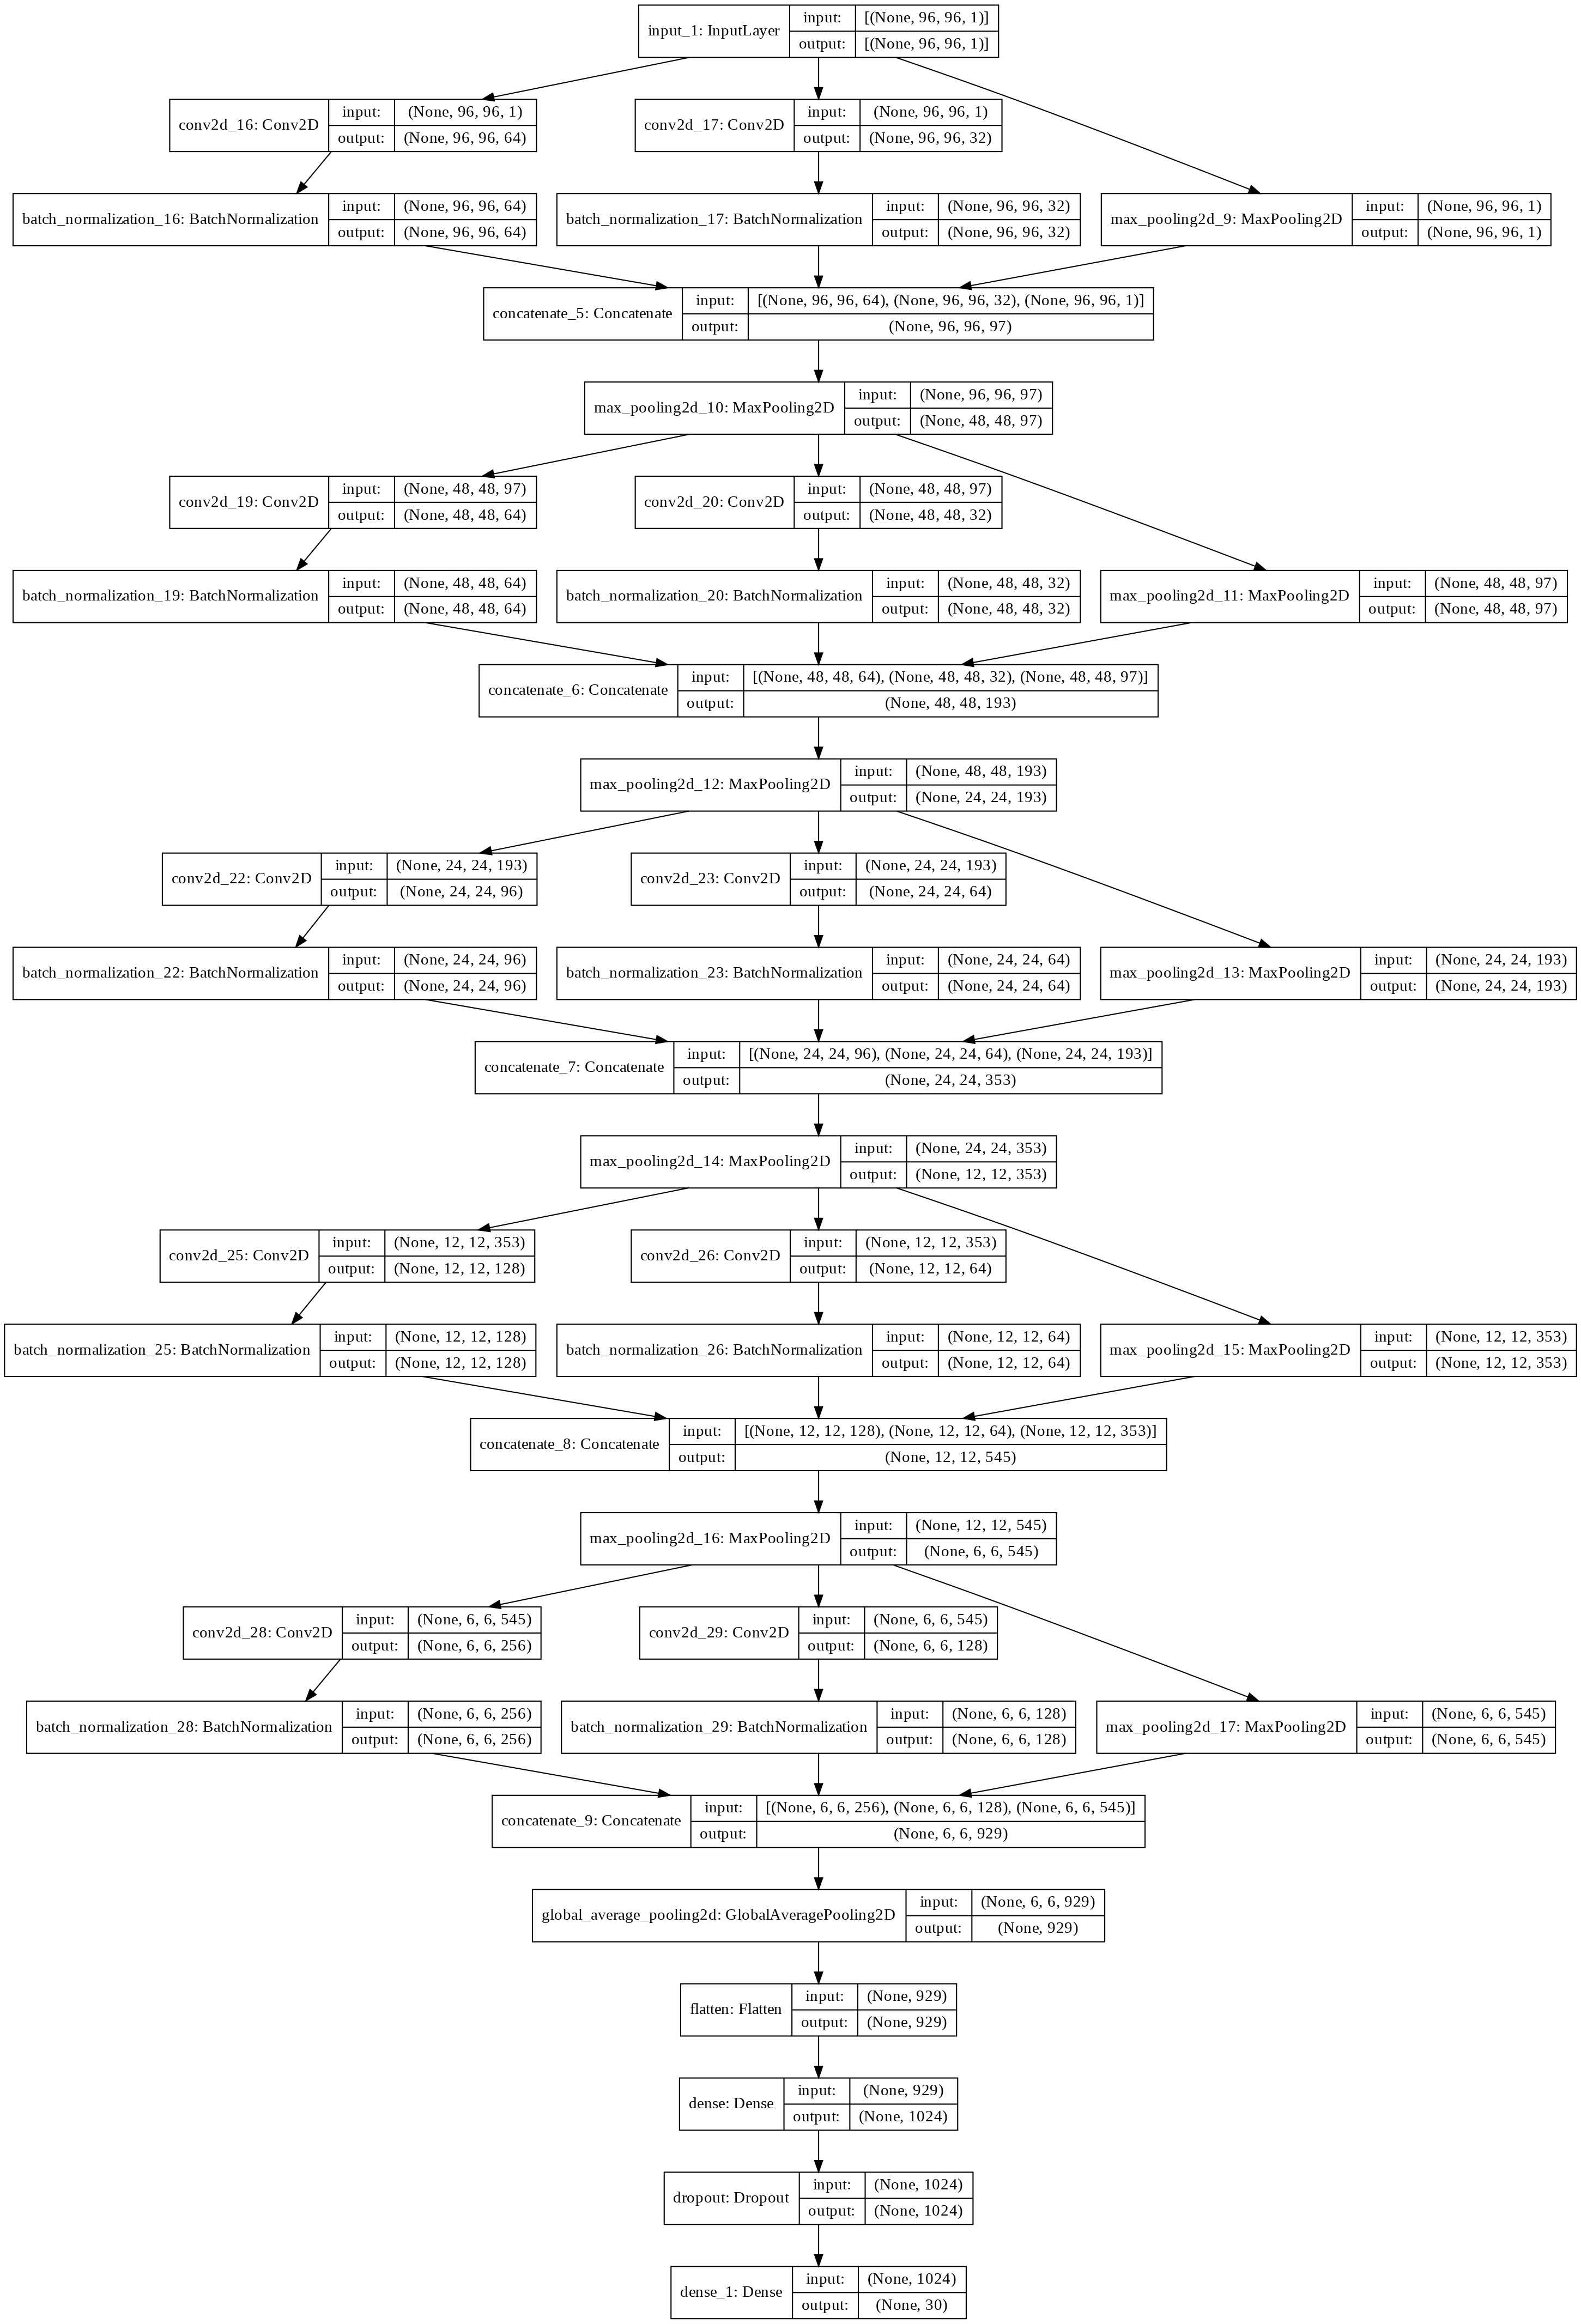

In [ ]:
tf.keras.utils.plot_model(face_key_model2_aug, show_shapes=True, to_file=data_path + "/inception_like_model.png", dpi=150)

In [ ]:
face_key_model2_aug.compile(loss='mse', 
                       optimizer=Adam(learning_rate=3e-3), 
                       metrics=['mae'])

In [ ]:

face_key_model2_aug_train_clean = face_key_model2_aug.fit(aug_ims_train_final, aug_points_train_final, 
                                                  validation_split= 0.05, 
                                                  batch_size=64, epochs=300, 
                                                  callbacks=[customCallbacks(), reduce_lr], 
                                          verbose=0)

epoch num 49, train acc: 2.3779187202453613, validation acc: 2.267221212387085
epoch num 99, train acc: 2.0050692558288574, validation acc: 2.0755321979522705

Epoch 00130: ReduceLROnPlateau reducing learning rate to 0.002400000020861626.
epoch num 149, train acc: 1.7482725381851196, validation acc: 1.5835120677947998

Epoch 00183: ReduceLROnPlateau reducing learning rate to 0.0019200000911951066.
epoch num 199, train acc: 1.6922709941864014, validation acc: 1.6226741075515747

Epoch 00214: ReduceLROnPlateau reducing learning rate to 0.0015360000543296337.
epoch num 249, train acc: 1.5783627033233643, validation acc: 1.473602294921875

Epoch 00259: ReduceLROnPlateau reducing learning rate to 0.001228800043463707.
epoch num 299, train acc: 1.4743542671203613, validation acc: 1.169912338256836


<class 'list'>


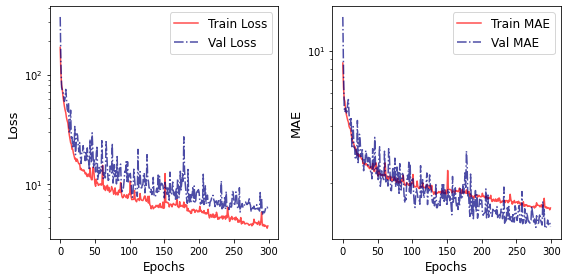

In [ ]:
mae = face_key_model2_aug_train_clean.history['mae']
# mae = [i for i in mae if i<60]
print (type(mae))
val_mae = face_key_model2_aug_train_clean.history['val_mae']
# val_mae = [i for i in val_mae if i<60]

loss = face_key_model2_aug_train_clean.history['loss']
# loss = [i for i in loss if i<1200]
val_loss = face_key_model2_aug_train_clean.history['val_loss']
# val_loss = [i for i in val_loss if i<1200]

fig = plt.figure(figsize=(8, 4))

fig.add_subplot(121)
plt.plot(range(len(loss)), loss, linestyle='-', color='red', alpha=0.7, label='Train Loss')
plt.plot(range(len(val_loss)), val_loss, linestyle='-.', color='navy', alpha=0.7, label='Val Loss')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=13)
plt.yscale('log')
plt.legend(fontsize=12)

fig.add_subplot(122)
plt.plot(range(len(mae)), mae, linestyle='-', color='red', alpha=0.7, label='Train MAE')
plt.plot(range(len(val_mae)), val_mae, linestyle='-.', color='navy', alpha=0.7, label='Val MAE')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('MAE', fontsize=13)
plt.yscale('log')
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig(data_path+'train_loss_mae.png', dpi=150)
plt.show()

In [ ]:
predict_points_aug2_clean = face_key_model2_aug.predict(test_ims)

print ('check shape of predicted points: ', predict_points_aug2_clean.shape)



check shape of predicted points:  (1783, 30)


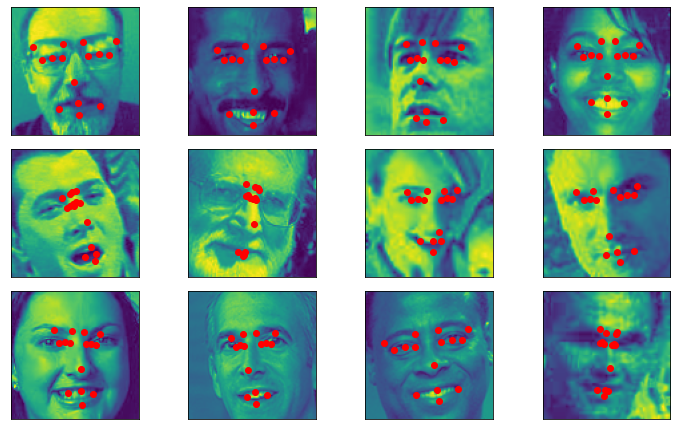

In [ ]:
fig = plt.figure(figsize=(10, 8))
npics= 12
count = 1
for i in range(npics):
  # ipic = i
  ipic = np.random.choice(test_ims.shape[0])
  ax = fig.add_subplot(npics/3 , 4, count, xticks=[],yticks=[])
  vis_im_keypoint_notstandard(test_ims[ipic], predict_points_aug2_clean[ipic], ax)
  count = count + 1


plt.tight_layout()
plt.savefig(data_path+'/prediction_keypoints.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)
plt.show()


In [ ]:
predict_points_aug2_s = predict_points_aug2_clean
print ('check max and min: ', predict_points_aug2_s.max(), predict_points_aug2_s.min())

check max and min:  94.00693 7.287162


In [ ]:
print ('check the new predict data frame: ', predict_points_aug2_s.shape)
predict_points_aug2_s[predict_points_aug2_s > 95.99] = 96.0
predict_points_aug2_s[predict_points_aug2_s < 0.0] = 0.0

print ('check max and min now: ', predict_points_aug2_s.max(), predict_points_aug2_s.min())

In [ ]:
test_predicts3 = pd.DataFrame(predict_points_aug2_s, columns = list(clean_keypoints_df.columns))

print ('check the new predict data frame: ', '\n')
test_predicts3.head(3)

In [ ]:
for i in range(lookup_table.shape[0]):
    lookup_table.Location[i] = test_predicts3.loc[lookup_table.ImageId[i]-1][lookup_table.FeatureName[i]]


In [ ]:
sub_form_table.Location = lookup_table.Location
new_submission = sub_form_table


In [ ]:
new_submission.head(3)


In [ ]:
# print (new_submission['Location'].max(), new_submission['Location'].min())